# 模块7-机器学习基础-基础篇-03-从线性回归到神经网络之线性回归篇-Sklearn实现

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 数据准备与预处理

In [8]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
data.data
data.target
data.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [10]:
data = pd.read_csv('./data/housevalue.csv', encoding='utf-8')
data.columns = [
    '住户收入的中位数', '房屋年龄的中位数', '平均房间数据', '平均卧室数目',
    '街区的人口', '平均入住率', '纬度', '经度','房屋的价格'
]
data.head()

,住户收入的中位数,房屋年龄的中位数,平均房间数据,平均卧室数目,街区的人口,平均入住率,纬度,经度,房屋的价格
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [19]:
from sklearn.model_selection import train_test_split
from rich import print

X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:,:-1], #特征
    data.iloc[:,-1], # 标签
    test_size=0.3,  # 划分比例
    random_state=1210 # 随机数种子
)

In [20]:
print(f"训练集特征的大小为: {X_train.shape}")
print(f"训练集标签的大小为: {y_train.shape}")
print(f"测试集特征的大小为: {X_test.shape}")
print(f"测试集标签的大小为: {y_test.shape}")

训练集特征的大小为: (14448, 8)

训练集标签的大小为: (14448,)

测试集特征的大小为: (6192, 8)

测试集标签的大小为: (6192,)

## 模型建立

In [21]:
from sklearn.linear_model import LinearRegression as LR

In [37]:
reg = LR(fit_intercept=True, # 是否计算模型的截距项
        copy_X=True,  # 默认是True, 程序会复制数据X,否则X可能会被覆盖
        n_jobs=-1,  # 所有的内核都参与运算
        positive=False, # 强制线性模型的系数为正
        )          #  实例化一个线性回归模型对象
reg.fit(X_train, y_train)  # 使用该模型进行训练
y_hat = reg.predict(X_test)  # 训练好的模型进行预测
y_hat   # 查看预测的结果

array([1.7427149 , 1.0351381 , 2.23547189, ..., 1.30589654, 1.68168387,
       2.1008634 ])

- fit_intercept: 是否计算模型的截距项
- copy_X : 默认是True, 程序会复制数据X,否则X可能会被覆盖
- positive=False,  强制线性模型的系数为正

In [45]:
reg.coef_   # 返回特征的系数
[*zip(reg.feature_names_in_, reg.coef_)] #返回特征的名称和特征的系数
reg.intercept_ #线性回归的中的截距项目
reg.rank_ #返回特征矩阵的rank
reg.singular_ # 返回特征矩阵的奇异值,
reg.n_features_in_ # 返回特征的数量

8

## 回归类模型的评估指标

### 是否预测了正确的数值
这里一般使用MSE来评价来作为评估指标

$$ \frac{1}{N}\sum(y_i - y^{\hat})^2 $$

In [51]:
from sklearn.metrics import mean_squared_error as MSE

MSE(y_hat, y_test) # 方法1

0.5198138702278865

In [59]:
from sklearn.model_selection import cross_val_score
cross_val_score(reg,X_train, y_train, cv=5,scoring='neg_mean_squared_error')

array([-0.56944385, -0.48865454, -0.53811748, -0.50304552, -0.55486849])

In [56]:
from sklearn.metrics import mean_absolute_error as MAE
MAE(y_hat, y_test)
cross_val_score(reg,X_train, y_train, cv=10,scoring='neg_mean_absolute_error').mean()

-0.532778333806857

CV = 10
1. 将X_train划分为10个大小的相似的子集,成为'折',分为10个,那就是10折交叉验证
2. 模型的测试与训练: 10个子集里面,我拿9个子集训练模型,剩下的1个测试模型,
3. 重复上述过程K次,每次都选择不通的测试集,
4. 结果计算
    1. 记录每次迭代中模型的评估指标,比如准确率,均方误差
    2. 最后,计算所有K次评估的平均值以及标准差,这为模型性能提供了一个稳健的估计

做交叉验证的好处:
1. 提供模型在不同数据集划分下的性能的平均值,减少单词划分带来的随机性
2. 帮助检测模型是否过拟合或者欠拟合
3. 提供更稳健的模型评估结果,提高模型选择的可靠性

### 是否拟合了足够的信息

只探索数据是否预测准确说不够的,除了数据本身的数值大小之外,我们还希望我们都模型能够捕捉到数据的规律,比如数据的分布,单调性等,但是这些 并没有办法通过MSE来衡量

$$R^2 = 1 - \frac{\sum_{i=0}^m (y_i - \hat{y})^2} {\sum_{i=0}^m (y_i - \bar{y})^2 }$$

In [67]:
from sklearn.metrics import r2_score

In [64]:
# 请务必注意,输入的时候,先输入真实值,后输入预测值,两者顺序乱了,会导致相同评估指标不同的结果
r2_score(y_hat, y_test)  # 错误师范
r2_score(y_test, y_hat)  # 虽然可以用,但是不建议,
r2_score(y_pred=y_hat, y_true=y_test)  # 建议使用关键字从传参

0.6131935096962662

In [65]:
from sklearn.model_selection import cross_val_score
cross_val_score(reg,X_train, y_train, cv=10,scoring='r2').mean()

0.5983794887137079

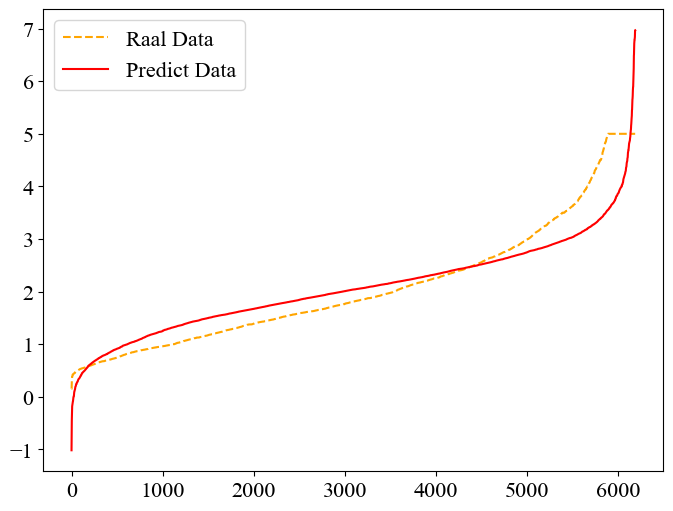

In [66]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,6),dpi=100)
sorted(y_test)

plt.plot(range(len(y_test)), sorted(y_test),c='orange',ls='--', label='Raal Data')
         
plt.plot(range(len(y_hat)), sorted(y_hat),c='red', label='Predict Data')

plt.legend()

plt.show()

In [68]:
rng = np.random.RandomState(1210)
X = rng.randn(100,80)
y = rng.randn(100)

In [72]:
cross_val_score(LR(), X, y, cv=5, scoring='r2')

array([-1588.66069835,   -21.04452071,   -14.13640302,   -55.35250717,
        -307.18284983])

- 极端情况: R^2为负数

1. 模型不合适: 模型没有捕捉到任何数据结构,甚至比用均值预测还要差, R^2就可能是负数
2. 数据噪声太大: 如果数据当中存在大量噪声,模型可能无法有效学习 任何规律
3. 预测偏差过大,当预测值原理实际时,误差 平方和可能超过总的平方和,此时R^2就是负数
4. 特征与目标无关: 特征与目标变了没有显著关系时, 回归模型的效果可能就很差
    
如何规避这种问题:
1. 检查数据: 确保特征和目标变变量之间的某种关系,可以通过绘图或者计算想关系数来检查'
2.  特征工程: 尝试提取更有意义的特征.
3. 模型选择: 如果线性回归模型不适合,可以尝试其他模型,
4. 增加样本量: 更大的样本量可以帮助模型更好的学习数据的结构

2. 回归任务: 使用线性回归完成网店销售额的预测工作

任务要求:

    1. 数据集的划分
    2. 模型的搭建
    3. 模型的预测
    4. 模型的评估
    5. 模型的保存与存储